In [1]:
from models.codec.kmeans.kmeans_model import KMeans, KMeansEMA
from transformers import Wav2Vec2BertModel
from transformers import SeamlessM4TFeatureExtractor
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import librosa
from IPython.display import Audio
import matplotlib.pyplot as plt

In [2]:
kmeans_model = KMeansEMA(1024, 1024)
model_path = "/blob/v-yuancwang/codec_ckpt/semantic_kmeans/semantic_kmeans_ema_debug_libritts/checkpoint/epoch-0010_step-0002000_loss-679.313721/pytorch_model.bin"
kmeans_model.load_state_dict(torch.load(model_path))
kmeans_model.eval()
kmeans_model.cuda()

KMeansEMA(
  (dumy_emb): Embedding(1, 1)
)

In [3]:
wav_path_0 = "/home/t-zeqianju/yuancwang/temp_test_dataset/libritts-train-clean-100/train-clean-100/8468/294887/8468_294887_000017_000002.wav"
wav_path_1 = "/home/t-zeqianju/yuancwang/temp_test_dataset/libritts-train-clean-100/train-clean-100/5022/29405/5022_29405_000025_000003.wav"
wav_path_2 = "/home/t-zeqianju/yuancwang/temp_test_dataset/libritts-train-clean-100/train-clean-100/5022/29411/5022_29411_000051_000002.wav"
wav_path_4 = "/home/t-zeqianju/yuancwang/temp_test_dataset/libritts-train-clean-100/train-clean-100/1502/122619/1502_122619_000052_000002.wav"
# concat 4 wav
wav_0, sr = librosa.load(wav_path_0, sr=16000)
wav_1, sr = librosa.load(wav_path_1, sr=16000)
wav_2, sr = librosa.load(wav_path_2, sr=16000)
wav_4, sr = librosa.load(wav_path_4, sr=16000)
wav = np.concatenate([wav_0, wav_1, wav_2, wav_4])
Audio(wav, rate=16000)

In [4]:
len(wav) // 320

1547

In [5]:
processor = SeamlessM4TFeatureExtractor.from_pretrained("facebook/w2v-bert-2.0")
semantic_model = Wav2Vec2BertModel.from_pretrained("facebook/w2v-bert-2.0")
semantic_model.eval()
semantic_model = semantic_model.cuda()
layer_idx = 15
if layer_idx == 23:
    output_idx = 0
else:
    output_idx = layer_idx + 2
stat_mean_var = torch.load("/home/t-zeqianju/yuancwang/mls_wav2vec2bert_stats.pt")
semantic_mean = stat_mean_var["mean"]
semantic_std = torch.sqrt(stat_mean_var["var"])
semantic_mean = semantic_mean.to("cuda")
semantic_std = semantic_std.to("cuda")
print("semantic mean: ", semantic_mean, "semantic std: ", semantic_std)

semantic mean:  tensor([-0.1368, -0.1855,  0.2000,  ...,  0.0310,  0.1405, -0.1794],
       device='cuda:0', dtype=torch.float64) semantic std:  tensor([0.3364, 0.4122, 0.3472,  ..., 0.3680, 0.3667, 0.3582], device='cuda:0',
       dtype=torch.float64)


In [6]:
speech_data = wav
inputs = processor(speech_data, sampll_rate=16000)
input_features = inputs["input_features"]
print(input_features.shape)
attention_mask = inputs["attention_mask"]
print(attention_mask.shape)

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


(1, 1547, 160)
(1, 1547)


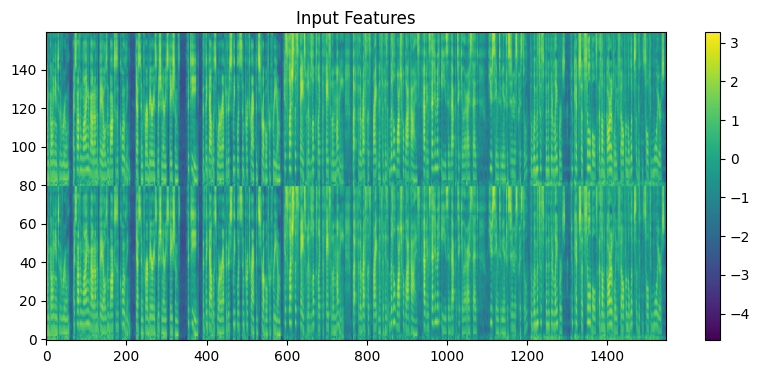

In [7]:
# plot input features
plt.figure(figsize=(10, 4))
plt.imshow(input_features[0].T, aspect="auto", origin="lower")
plt.colorbar()
plt.title("Input Features")
plt.show()

In [8]:
input_features = torch.tensor(input_features).cuda()
attention_mask = torch.tensor(attention_mask).cuda()

In [9]:
with torch.no_grad():
    vq_emb = semantic_model(
        input_features=input_features,
        attention_mask=attention_mask,
        output_hidden_states=True,
    )
    feat = vq_emb.hidden_states[output_idx]  # B x T x C
    feat = (feat - semantic_mean.to(feat)) / semantic_std.to(feat)

In [10]:
vq_id, _ = kmeans_model.quantize(feat)
vq_id = vq_id.cpu().numpy()[0]
print(vq_id)

[621 578 989 ... 975 975 718]


In [11]:
unique, counts = np.unique(vq_id, return_counts=True)
idx = np.argsort(counts)[::-1]
unique = unique[idx]
counts = counts[idx]
print(unique)

[  93  373  622  616  833  275  830  168  680  338  321  894  579  764
  205  300  346  928  244  829  121  213  714  947  308  471  878  204
   46  877   63  415  108  743  301  411  551  969  192  974  675  623
  497  459  873  642   55  269  653  670  826  679  604  430  805 1003
  384  276  119  388   80  414  753  717  408  342  770  310  975  315
  966  478  823  296  385  377  122  232  803  672  809  821  812   79
 1002  505  492  818  432  948  468  166  419   98  723 1015  722  720
  307  225  744  404  400  750   82  397  757  396  558    6  112  771
  130  167  996  857  450  460  874  580  917  891  446  172  325  893
  210  139  235  340  985  983  191  555  188  161  600  495  153  461
  516  540  518  538  544  154  110  179  103  151  420  149  100  184
  434  574  133  491  136  187  661  435  657  482  686  687  562  162
  561  487  115  422  421  578  638  501  134  660  726  354  936  323
  920   41  918   43   45  339  905  901  341  885  884  347  880  879
  876 

In [18]:
idx = np.where(vq_id == 833)[0]
print(idx)

[ 748  749  752  753 1082 1083 1085 1087 1088 1090]


In [19]:
# concat
cat_wav = np.array([])
for i in range(0, len(idx)):
    cat_wav = np.concatenate([cat_wav, wav[(idx[i]-5) * 320: (idx[i] + 5) * 320]])
    cat_wav = np.concatenate([cat_wav, np.zeros(16000)])
Audio(cat_wav, rate=16000)

# ABX test

In [13]:
test_path = "/home/t-zeqianju/yuancwang/LibriSpeech/test-clean"
for spk in os.listdir(test_path):
    for chapter in os.listdir(os.path.join(test_path, spk)):
        for wav_file in os.listdir(os.path.join(test_path, spk, chapter)):
            if not wav_file.endswith(".flac"):
                continue
            wav_path = os.path.join(test_path, spk, chapter, wav_file)
            wav, sr = librosa.load(wav_path, sr=16000)
            inputs = processor(wav, sampling_rate=16000)
            input_features = inputs["input_features"]
            attention_mask = inputs["attention_mask"]
            input_features = torch.tensor(input_features).cuda()
            attention_mask = torch.tensor(attention_mask).cuda()
            with torch.no_grad():
                vq_emb = semantic_model(
                    input_features=input_features,
                    attention_mask=attention_mask,
                    output_hidden_states=True,
                )
                feat = vq_emb.hidden_states[output_idx]
                feat = (feat - semantic_mean.to(feat)) / semantic_std.to(feat)
                # print(feat.shape)
                quantize, _, _ = kmeans_model(feat)
                # print(quantize.shape)
                uid = wav_file.split(".")[0]
                # print(uid)
                quantize = quantize.cpu().numpy()[0]
                save_path = os.path.join("/home/t-zeqianju/yuancwang/ABX_features/test-clean/kmeans_debug", uid + ".npy")
                np.save(save_path, quantize)